In [107]:
import numpy as np
import pandas as pd
import subprocess
import os
import sys
import argparse
import glob
import time
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
from urllib.request import urlopen
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.time import Time
from contextlib import closing

C:\Users\Jack Pope\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Jack Pope\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



In [45]:
import warnings
from astropy.wcs import FITSFixedWarning

# Suppress specific FITSFixedWarnings
warnings.filterwarnings('ignore', category=FITSFixedWarning)

### Get Tiles Function

In [4]:
import urllib.request

url = 'https://archive-new.nrao.edu/vlass/VLASS_dyn_summary.php'
output_file = 'VLASS_dyn_summary.php'

urllib.request.urlretrieve(url, output_file)

print(f'File downloaded to: {output_file}')

File downloaded to: VLASS_dyn_summary.php


In [22]:
def get_tiles():
    """ Get tiles 
    I ran wget https://archive-new.nrao.edu/vlass/VLASS_dyn_summary.php
    """
    fname = "VLASS_dyn_summary.php"
    inputf = open(fname, "r")
    lines = inputf.readlines()
    inputf.close()

    header = list(filter(None, lines[0].split("  ")))
    # get rid of white spaces
    header = np.array([val.strip() for val in header])

    names = []
    dec_min = []
    dec_max = []
    ra_min = []
    ra_max = []
    obsdate = []
    epoch = []

    # Starting at lines[3], read in values
    for line in lines[3:]:
        dat = list(filter(None, line.split("  "))) 
        dat = np.array([val.strip() for val in dat]) 
        names.append(dat[0])
        dec_min.append(float(dat[1]))
        dec_max.append(float(dat[2]))
        ra_min.append(float(dat[3]))
        ra_max.append(float(dat[4]))
        obsdate.append(dat[6])
        epoch.append(dat[5])

    names = np.array(names)
    dec_min = np.array(dec_min)
    dec_max = np.array(dec_max)
    ra_min = np.array(ra_min)
    ra_max = np.array(ra_max)
    obsdate = np.array(obsdate)
    epoch = np.array(epoch)

    return (names, dec_min, dec_max, ra_min, ra_max, epoch, obsdate)


get_tiles()


(array(['T01t01', 'T01t01', 'T01t01', ..., 'T32t02', 'T32t02', 'T32t02'],
       dtype='<U6'),
 array([-40., -40., -40., ...,  85.,  85.,  85.]),
 array([-36., -36., -36., ...,  90.,  90.,  90.]),
 array([ 0.,  0.,  0., ..., 12., 12., 12.]),
 array([ 0.5,  0.5,  0.5, ..., 24. , 24. , 24. ]),
 array(['VLASS2.1', 'VLASS3.1', 'VLASS1.1', ..., 'VLASS2.1', 'VLASS3.1',
        'VLASS1.1'], dtype='<U8'),
 array(['2020-10-25', '2023-06-06', '2018-02-07', ..., '2020-08-29',
        '2023-04-24', '2017-09-29'], dtype='<U13'))

### Search Tiles Function


In [5]:
def search_tiles(tiles, c):
    """ Now that you've processed the file, search for the given RA and Dec
    
    Parameters
    ----------
    c: SkyCoord object
    """
    ra_h = c.ra.hour
    dec_d = c.dec.deg
    names, dec_min, dec_max, ra_min, ra_max, epochs, obsdate = tiles
    has_dec = np.logical_and(dec_d > dec_min, dec_d < dec_max)
    has_ra = np.logical_and(ra_h > ra_min, ra_h < ra_max)
    in_tile = np.logical_and(has_ra, has_dec)
    name = names[in_tile]
    epoch = epochs[in_tile]
    date = obsdate[in_tile]
    if len(name) == 0:
        print("Sorry, no tile found.")
        return None, None, None
    else:
        return name, epoch, date

### Get Subtiles Function

In [6]:
def get_subtiles(tilename, epoch):
    """ For a given tile name, get the filenames in the VLASS directory.
    Parse those filenames and return a list of subtile RA and Dec.
    RA and Dec returned as a SkyCoord object
    """
    if epoch =='VLASS1.2':
        epoch = 'VLASS1.2v2'
    elif epoch =='VLASS1.1':
        epoch = 'VLASS1.1v2'
    url_full = 'https://archive-new.nrao.edu/vlass/quicklook/%s/%s/' %(epoch,tilename)
    urlpath = urlopen(url_full)
    # Get site HTML coding
    string = (urlpath.read().decode('utf-8')).split("\n")
    # clean the HTML elements of trailing and leading whitespace
    vals = np.array([val.strip() for val in string])
    # Make list of HTML link elements
    keep_link = np.array(["href" in val.strip() for val in string])
    # Make list of HTML elements with the tile name
    keep_name = np.array([tilename in val.strip() for val in string])
    # Cross reference the two lists above to keep only the HTML elements with the tile name and a link
    string_keep = vals[np.logical_and(keep_link, keep_name)]
    # Keep only the links from the HTML elements (they are the 7th element since 6 quote marks precede it)
    fname = np.array([val.split("\"")[7] for val in string_keep])
    # Take out the element of the link that encodes the RA and declination
    pos_raw = np.array([val.split(".")[4] for val in fname])
    if '-' in pos_raw[0]:
        # dec < 0
        ra_raw = np.array([val.split("-")[0] for val in pos_raw])
        dec_raw = np.array([val.split("-")[1] for val in pos_raw])
    else:
        # dec > 0
        ra_raw = np.array([val.split("+")[0] for val in pos_raw])
        dec_raw = np.array([val.split("+")[1] for val in pos_raw])
    ra = []
    dec = []
    for ii,val in enumerate(ra_raw):
        # 24 hours is the same as hour 0
        if val[1:3] == '24':
            rah = '00'
        else:
            rah = val[1:3]
        # calculate RA in hours mins and seconds
        hms = "%sh%sm%ss" %(rah, val[3:5], val[5:])
        ra.append(hms)
        # calculate Dec in degrees arcminutes and arcseconds
        dms = "%sd%sm%ss" %(
                dec_raw[ii][0:2], dec_raw[ii][2:4], dec_raw[ii][4:])
        dec.append(dms)
    ra = np.array(ra)
    dec = np.array(dec)
    c_tiles = SkyCoord(ra, dec, frame='icrs')
    return fname, c_tiles

### Get Numpy Cutout Function

In [ ]:

def get_cutout(imname, name, c, epoch, save_dir, download_image = True):

    # Position of source
    ra_deg = c.ra.deg
    dec_deg = c.dec.deg

    print("Cutout centered at position %s, %s" % (ra_deg, dec_deg))

    try:
        # Open image and establish coordinate system
        with pyfits.open(imname) as hdul:
            im = hdul[0].data[0, 0]
            w = WCS(hdul[0].header)
        
            # Find the source position in pixels.
            # This will be the center of our image.
            src_pix = w.wcs_world2pix([[ra_deg, dec_deg, 0, 0]], 0)
            x = src_pix[0, 0] + 1
            y = src_pix[0, 1] + 1

            # Check if the source is actually in the image
            pix1 = hdul[0].header['CRPIX1']
            pix2 = hdul[0].header['CRPIX2']
            badx = np.logical_or(x < 0, x > 2 * pix1)
            bady = np.logical_or(y < 0, y > 2 * pix2)
            if np.logical_and(badx, bady):
                print("Tile has not been imaged at the position of the source")
                return None
            else:
                # Set the dimensions of the image
                # Say we want it to be 12 arcseconds on a side,
                # to match the DES images
                image_dim_arcsec = 12
                delt1 = hdul[0].header['CDELT1']
                delt2 = hdul[0].header['CDELT2']
                cutout_size = image_dim_arcsec / 3600  # in degrees
                dside1 = -cutout_size / 2. / delt1
                dside2 = cutout_size / 2. / delt2

                vmin = -1e-4
                vmax = 1e-3

                im_plot_raw = im[int(y - dside1):int(y + dside1), int(x - dside2):int(x + dside2)]
                im_plot = np.ma.masked_invalid(im_plot_raw)

                # 3-sigma clipping (find root mean square of values that are not above 3 standard deviations)
                rms_temp = np.ma.std(im_plot)
                keep = np.ma.abs(im_plot) <= 3 * rms_temp
                rms = np.ma.std(im_plot[keep])

                # Find peak flux in entire image
                # Check if im_plot.flatten() is empty
                if im_plot.flatten().size == 0:
                    print("Tile has not been imaged at the position of the source")
                    return None
                else:
                    peak_flux = np.ma.max(im_plot.flatten())

                fig, ax = plt.subplots(figsize=(6, 6))  # Create a square figure
                ax.imshow(
                    np.flipud(im_plot),
                    extent=[-0.5 * cutout_size * 3600., 0.5 * cutout_size * 3600.,
                            -0.5 * cutout_size * 3600., 0.5 * cutout_size * 3600],
                    vmin=vmin, vmax=vmax, cmap='YlOrRd')

                peakstr = "Peak Flux %s mJy" % (np.round(peak_flux * 1e3, 3))
                rmsstr = "RMS Flux %s mJy" % (np.round(rms * 1e3, 3))

                title_str = r'$\bf{%s}$' % epoch + '\n' + '%s: %s;\n%s' % (name, peakstr, rmsstr)
                ax.set_title(title_str, fontsize=10)
                ax.set_xlabel("Offset in RA (arcsec)")
                ax.set_ylabel("Offset in Dec (arcsec)")

                ax.set_aspect('equal')  # Ensure the plot is square
                ax.figure.tight_layout()  # Adjust layout to fit everything nicely

                filename = f"{name}_{epoch}.png"
                filepath = os.path.join(save_dir, filename)
                plt.savefig(filepath)
                plt.close(fig)

                print(f"PNG saved successfully: {filepath}")

        return peak_flux, rms, filepath

    except Exception as e:
        print(f"An error occurred while processing {imname}: {e}")
        return None

### Run Search Function

In [149]:
from astropy.coordinates import SkyCoord
from astropy import units as u


# Example coordinates
coord_str = "13:14:25.45 +50:58:39.7"
c1 = SkyCoord(coord_str, unit=(u.hourangle, u.deg))

name = "ZTF18aagrtxs"


coord_str2 = "10:35:32.09 +37:38:59.0"
name = "ZTF17aabtvsy"
c2 = SkyCoord(coord_str2, unit=(u.hourangle, u.deg))


file_path = 'ia_supernovae_stuff/ia_full_data/ia_supernovae.csv'
ia_supernovae_df = pd.read_csv(file_path)
test_df = ia_supernovae_df.iloc[:100]


### Multiple objects to Event List
and helper functions

In [150]:
def dataframe_to_objects(dataframe, name_id_col = 'ZTFID', ra_id_col = 'RA', dec_id_col = 'Dec'):

    new_dataframe = []
    for i, object in dataframe.iterrows():
        name = object[name_id_col]
        coord_str = object[ra_id_col] + object[dec_id_col]
        c = SkyCoord(coord_str, unit=(u.hourangle, u.deg))
        object_data = {'Name': name,
                       'Skycoord': c}
        new_dataframe.append(object_data)
    return new_dataframe

dataframe_to_objects(test_df)

[{'Name': 'ZTF17aabtvsy',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (158.88370833, 37.64972222)>},
 {'Name': 'ZTF17aacldgo',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (47.35145833, -4.89422222)>},
 {'Name': 'ZTF17aadlxmv',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (127.44829167, 33.90633333)>},
 {'Name': 'ZTF18aaaonon',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (154.77295833, 14.40461111)>},
 {'Name': 'ZTF18aaaqexr',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (175.77654167, 15.56713889)>},
 {'Name': 'ZTF18aabdgik',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (175.59866667, 10.26408333)>},
 {'Name': 'ZTF18aaceepu',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (146.99766667, 34.74180556)>},
 {'Name': 'ZTF18aadlaxo',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (120.64895833, 50.92252778)>},
 {'Name': 'ZTF18aadxnul',
  'Skycoord': <SkyCoord (ICRS): (ra, dec) in deg
      (98.50770833, 43.4090277

In [ ]:
def search_tiles_and_sort(c):
    """
    Gets tiles and sorts the available epochs in order, returning tiles, epochs, and their observed dates
    """

    tiles = get_tiles()
    tilenames, epochs, obsdates = search_tiles(tiles, c)

    # Sort the tiles by the epochs so most recent goes last
    combined = list(zip(tilenames, epochs, obsdates))
    combined_sorted = sorted(combined, key=lambda x: x[1])
    tilenames, epochs, obsdates = zip(*combined_sorted)

    return tilenames, epochs, obsdates

(('T20t14', 'T20t14', 'T20t14'),
 ('VLASS1.2', 'VLASS2.2', 'VLASS3.2'),
 ('2019-05-03', '2021-11-11', '2024-07-21'))

In [ ]:
def boolean_observed_tiles(tilenames):
    """
    Checks if there is a list of tilenames (from search_tiles_and_sort) or if it is just None

    Returns True if there are tiles
    Returns False if there are none
    """
    if tilenames[0] is None:
        return False
    else:
        return True

In [153]:
def object_to_multiple_epochs(name, c):
    """
    Takes the list of lists from search_tiles_and_sort and makes them into separate dictionaries,
each representing a unique epoch-date observed
    """

    object_lists = []
    set_list = search_tiles_and_sort(c)
    # get the length of the individual lists (how many epochs show up)
    for x in range(len(set_list[0])):
        obs = {'Name': name,
               'c': c,
               'Tile': set_list[0][x],
               'Epoch': set_list[1][x],
               'Date': set_list[2][x]}
        object_lists.append(obs)

    return object_lists
        


In [166]:
def multiple_objects_to_event_list(dataframe, name_id_col = 'ZTFID', ra_id_col = 'RA', dec_id_col = 'Dec'):
    
    """ Given a pandas dataframe with name, ra, and dec, returns the a list of dictionaries
    which each have the name, skycoord, tile, epoch, and date of observation
    """

    final_object_epoch_list = []
    list_dict = dataframe_to_objects(dataframe, name_id_col, ra_id_col, dec_id_col)
    for obj in list_dict:
        name = obj['Name']
        c = obj['Skycoord']
        list_epoch_tiles = object_to_multiple_epochs(name, c)
        for x in list_epoch_tiles:
            final_object_epoch_list.append(x)

    return final_object_epoch_list
    
y = multiple_objects_to_event_list(test_df)
y

[{'Name': 'ZTF17aabtvsy',
  'c': <SkyCoord (ICRS): (ra, dec) in deg
      (158.88370833, 37.64972222)>,
  'Tile': 'T20t14',
  'Epoch': 'VLASS1.2',
  'Date': '2019-05-03'},
 {'Name': 'ZTF17aabtvsy',
  'c': <SkyCoord (ICRS): (ra, dec) in deg
      (158.88370833, 37.64972222)>,
  'Tile': 'T20t14',
  'Epoch': 'VLASS2.2',
  'Date': '2021-11-11'},
 {'Name': 'ZTF17aabtvsy',
  'c': <SkyCoord (ICRS): (ra, dec) in deg
      (158.88370833, 37.64972222)>,
  'Tile': 'T20t14',
  'Epoch': 'VLASS3.2',
  'Date': '2024-07-21'},
 {'Name': 'ZTF17aacldgo',
  'c': <SkyCoord (ICRS): (ra, dec) in deg
      (47.35145833, -4.89422222)>,
  'Tile': 'T09t05',
  'Epoch': 'VLASS1.1',
  'Date': '2017-11-28'},
 {'Name': 'ZTF17aacldgo',
  'c': <SkyCoord (ICRS): (ra, dec) in deg
      (47.35145833, -4.89422222)>,
  'Tile': 'T09t05',
  'Epoch': 'VLASS2.1',
  'Date': '2020-09-13'},
 {'Name': 'ZTF17aacldgo',
  'c': <SkyCoord (ICRS): (ra, dec) in deg
      (47.35145833, -4.89422222)>,
  'Tile': 'T09t05',
  'Epoch': 'VLASS3.

In [13]:
def pull_observed_tiles(most_recent_epoch = "VLASS3.2"):
    """
    Get all tiles that have been observed and put them into a list
    """

    url_full = 'https://archive-new.nrao.edu/vlass/quicklook/%s/' %(most_recent_epoch)
    with closing(urlopen(url_full)) as urlpath:
        # Get site HTML coding
        string = (urlpath.read().decode('utf-8')).split("\n")
        # clean the HTML elements of trailing and leading whitespace
        vals = np.array([val.strip() for val in string])
        # Make list of useful html elements
        files = np.array(['alt="[DIR]"' in val.strip() for val in string])
        useful = vals[files]
        # Splice out the name from the link
        obsname = np.array([val.split("\"")[7] for val in useful])
        observed_tiles_current_epoch = np.char.replace(obsname, '/', '')
        
    return observed_tiles_current_epoch

In [15]:
def check_obsdate(obsdate):
    """
    Checks an observed date and converts it to the proper date format (iso)
        if it is not "Not Submitted" or "Scheduled
    
    """
    # first check that the date isn't a special description
    if obsdate not in ['Scheduled', 'Not submitted']:
        try:
            obsdate = Time(obsdate, format='iso')
        except ValueError as e:
            print(f"Invalid date format: {obsdate}. Error: {e}")
            obsdate = 'Invalid date'
    # if it is, just say it's an invalid date
    else:
        obsdate = f"Invalid Date: '{obsdate}'"

    return obsdate

In [167]:
def adjust_epoch(epoch):
    """
    Changes the name of the epoch from VLASS1.1 and VLASS1.2 to VLASS1.1v2 and 1.2v2 respectively
    """
    # adjust epoch names to properly match
    if epoch=='VLASS1.2':
        epoch = 'VLASS1.2v2'
    elif epoch =='VLASS1.1':
        epoch = 'VLASS1.1v2'

    return epoch

In [168]:
def check_epoch_observed(epoch, tilename, observed_tiles_current_epoch):
    """
    Checks if the tile is observed based on what epoch we're in
    """
    # define past and present epochs
    past_epochs = ["VLASS1.1v2", "VLASS1.2v2", "VLASS2.1", "VLASS2.2", "VLASS3.1"]
    current_epoch = "VLASS3.2"

    # if it's a past epoch, we know it was observed
    if epoch in past_epochs:
        observed = True
    else:
        # if it's in current epoch, we need to check if it's been observed yet
        if epoch == current_epoch:
            # check if tile has been observed
            if tilename in observed_tiles_current_epoch:
                observed = True
        # if different epoch or hasn't been observed, set observed to False
        else:
            observed = False

    return observed
    

In [78]:
def get_and_check_subtile(c, epoch, tilename):
    """
    If the tile was assumed to be observed, get the nearest subtile to the coordinates of the object
    """
    subtiles, c_tiles = get_subtiles(tilename, epoch)
    # check that there are actually some subtiles
    if c_tiles == []:
        subtile = None
    else:
        # Find angular separation from the tiles to the location
        dist = c.separation(c_tiles)
        # Find tile with the smallest separation 
        subtile = subtiles[np.argmin(dist)]

    return subtile

get_and_check_subtile(c2, 'VLASS1.2', 'T20t14')

'VLASS1.2.ql.T20t14.J103631+373000.10.2048.v1/'

In [165]:
def image_and_url_getter(subtile, epoch, tilename):
    """
    Given a subtile, return the NRAO url
    """
    fits_url = "https://archive-new.nrao.edu/vlass/quicklook/%s/%s/%s" %(
            epoch, tilename, subtile)
    fitsname = "%s.I.iter1.image.pbcor.tt0.subim.fits" %subtile[0:-1]

    return fits_url, fitsname

image_and_url_getter('VLASS1.2.ql.T20t14.J103631+373000.10.2048.v1/', 'VLASS1.2v2', 'T20t14')

('https://archive-new.nrao.edu/vlass/quicklook/VLASS1.2v2/T20t14/VLASS1.2.ql.T20t14.J103631+373000.10.2048.v1/',
 'VLASS1.2.ql.T20t14.J103631+373000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits')

In [76]:
import os
import subprocess

def get_fits(fits_url, fitsname, fits_dir="ia_fits"):
    """
    Given the fits_url and fitsname, checks if the FITS file is downloaded in fits_dir
    and downloads it if it hasn't been already.
    """
    # Ensure the directory exists
    if not os.path.exists(fits_dir):
        os.makedirs(fits_dir)

    # Define the local path for the FITS file
    local_fits_path = os.path.join(fits_dir, fitsname)

    # Check if FITS file has already been downloaded
    if os.path.exists(local_fits_path):
        print(f"{local_fits_path} already exists. Skipping download.")
        return local_fits_path

    # Define the full URL for the FITS file
    full_fits_url = fits_url + fitsname

    # Attempt to download the FITS file
    try:
        print(f"Downloading {fitsname}...")
        subprocess.run(
            ["curl", "-o", local_fits_path, full_fits_url],
            check=True
        )

        # Confirm if the file was downloaded successfully
        if os.path.exists(local_fits_path):
            print(f"Downloaded {fitsname} successfully.")
            return local_fits_path
        else:
            print(f"Failed to download {fitsname}. File not found after download attempt.")
            return None

    except subprocess.CalledProcessError:
        # Handle any errors from the curl command
        print(f"Error downloading {fitsname}. Check the URL or network connection.")
        return None

l = image_and_url_getter('VLASS1.2.ql.T20t14.J103631+373000.10.2048.v1/', 'VLASS1.2v2', 'T20t14')
j = get_fits(l[0], l[1]) 

ia_fits\VLASS1.2.ql.T20t14.J103631+373000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits already exists. Skipping download.


In [81]:
def get_numpy_array(local_fits_path, c):
    """
    Given a fits path, gets the array centered around the skycoords c
    """

    # Position of source
    ra_deg = c.ra.deg
    dec_deg = c.dec.deg

    try:
        # Open image and establish coordinate system
        with pyfits.open(local_fits_path) as hdul:
            im = hdul[0].data[0, 0]
            w = WCS(hdul[0].header)
        
            # Find the source position in pixels.
            # This will be the center of our image.
            src_pix = w.wcs_world2pix([[ra_deg, dec_deg, 0, 0]], 0)
            x = src_pix[0, 0] + 1
            y = src_pix[0, 1] + 1

            # Check if the source is actually in the image
            pix1 = hdul[0].header['CRPIX1']
            pix2 = hdul[0].header['CRPIX2']
            badx = np.logical_or(x < 0, x > 2 * pix1)
            bady = np.logical_or(y < 0, y > 2 * pix2)
            if np.logical_and(badx, bady):
                print("Tile has not been imaged at the position of the source")
                return None
            else:
                # Set the dimensions of the image
                # Say we want it to be 12 arcseconds on a side,
                # to match the DES images
                image_dim_arcsec = 12
                delt1 = hdul[0].header['CDELT1']
                delt2 = hdul[0].header['CDELT2']
                cutout_size = image_dim_arcsec / 3600  # in degrees
                dside1 = -cutout_size / 2. / delt1
                dside2 = cutout_size / 2. / delt2

                im_plot_raw = im[int(y - dside1):int(y + dside1), int(x - dside2):int(x + dside2)]
                im_plot = np.ma.masked_invalid(im_plot_raw)

                return im_plot
            
    except Exception as e:
        print(f"An error occurred while processing {local_fits_path}: {e}")
        return None
    

practice_array = get_numpy_array(j, c2)

Cutout centered at position 158.88370833333332, 37.64972222222222


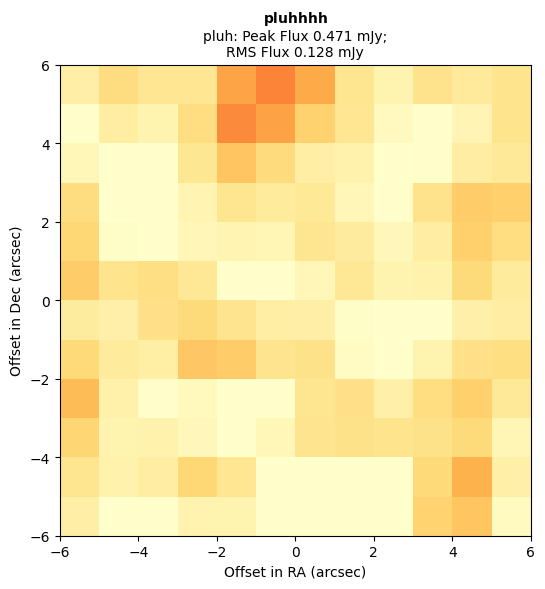

In [ ]:
def check_image(local_fits_path, name, c, epoch):

    # Position of source
    ra_deg = c.ra.deg
    dec_deg = c.dec.deg

    print("Cutout centered at position %s, %s" % (ra_deg, dec_deg))

    try:
        # Open image and establish coordinate system
        with pyfits.open(imname) as hdul:
            im = hdul[0].data[0, 0]
            w = WCS(hdul[0].header)
        
            # Find the source position in pixels.
            # This will be the center of our image.
            src_pix = w.wcs_world2pix([[ra_deg, dec_deg, 0, 0]], 0)
            x = src_pix[0, 0] + 1
            y = src_pix[0, 1] + 1

            # Check if the source is actually in the image
            pix1 = hdul[0].header['CRPIX1']
            pix2 = hdul[0].header['CRPIX2']
            badx = np.logical_or(x < 0, x > 2 * pix1)
            bady = np.logical_or(y < 0, y > 2 * pix2)
            if np.logical_and(badx, bady):
                print("Tile has not been imaged at the position of the source")
                return None
            else:
                # Set the dimensions of the image
                # Say we want it to be 12 arcseconds on a side,
                # to match the DES images
                image_dim_arcsec = 12
                delt1 = hdul[0].header['CDELT1']
                delt2 = hdul[0].header['CDELT2']
                cutout_size = image_dim_arcsec / 3600  # in degrees
                dside1 = -cutout_size / 2. / delt1
                dside2 = cutout_size / 2. / delt2

                vmin = -1e-4
                vmax = 1e-3

                im_plot_raw = im[int(y - dside1):int(y + dside1), int(x - dside2):int(x + dside2)]
                im_plot = np.ma.masked_invalid(im_plot_raw)

                # 3-sigma clipping (find root mean square of values that are not above 3 standard deviations)
                rms_temp = np.ma.std(im_plot)
                keep = np.ma.abs(im_plot) <= 3 * rms_temp
                rms = np.ma.std(im_plot[keep])

                # Find peak flux in entire image
                # Check if im_plot.flatten() is empty
                if im_plot.flatten().size == 0:
                    print("Tile has not been imaged at the position of the source")
                    return None
                else:
                    peak_flux = np.ma.max(im_plot.flatten())

                fig, ax = plt.subplots(figsize=(6, 6))  # Create a square figure
                ax.imshow(
                    np.flipud(im_plot),
                    extent=[-0.5 * cutout_size * 3600., 0.5 * cutout_size * 3600.,
                            -0.5 * cutout_size * 3600., 0.5 * cutout_size * 3600],
                    vmin=vmin, vmax=vmax, cmap='YlOrRd')

                peakstr = "Peak Flux %s mJy" % (np.round(peak_flux * 1e3, 3))
                rmsstr = "RMS Flux %s mJy" % (np.round(rms * 1e3, 3))

                title_str = r'$\bf{%s}$' % epoch + '\n' + '%s: %s;\n%s' % (name, peakstr, rmsstr)
                ax.set_title(title_str, fontsize=10)
                ax.set_xlabel("Offset in RA (arcsec)")
                ax.set_ylabel("Offset in Dec (arcsec)")

                ax.set_aspect('equal')  # Ensure the plot is square
                ax.figure.tight_layout()  # Adjust layout to fit everything nicely


    except Exception as e:
        print(f"An error occurred while processing {imname}: {e}")
        return None
    
check_image(j, 'pluh', c2, 'pluhhhh')

In [94]:
import os
import numpy as np

def save_npy_array(name, epoch, array, save_dir = 'ia_npy_arrays'):

    # Convert masked array to a regular ndarray (removes the mask)
    array = array.filled(np.nan)  # Replace masked values with NaN (or any value you prefer)

    # Make sure folder exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Define name of the file
    file_path = os.path.join(save_dir, f"{name}_{epoch}_array.npy")

    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"File {file_path} already exists. Skipping save.")
        return file_path # Exit the function if the file exists

    # Save the array as a .npy to the folder
    np.save(file_path, array)
    
    print(f"Array saved to {file_path}")
    return file_path

ia_fits\VLASS2.2.ql.T20t14.J103631+373000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits already exists. Skipping download.
File ia_npy_arrays\ZTF17aabtvsy_VLASS2.2_array.npy already exists. Skipping save.
Cutout centered at position 158.88370833333332, 37.64972222222222


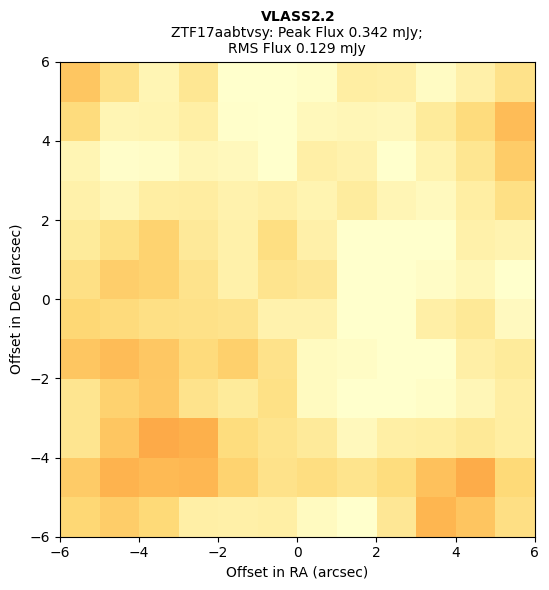

In [ ]:
def event_to_npy(name, c, tile, epoch, date):
    """ 
    Converts a single event, given name, skycoord, the tile, epoch, and date
    (individual objects from multiple_objects_to_events)
    and returns a npy array
    """
    ### MAKE SURE TO CHECK IF TILE EXISTSSSS
    
    # check if tile was observed
    curr_obs_tiles = pull_observed_tiles()
    epoch = adjust_epoch(epoch)
    observed = check_epoch_observed(epoch, tile, curr_obs_tiles)

    # if observed, check subtiles
    if observed:
        subtile = get_and_check_subtile(c, epoch, tile)
        if subtile is not None:
            fits_url, fitsname = image_and_url_getter(subtile, epoch, tile)
            local_fits_path = get_fits(fits_url, fitsname, fits_dir="ia_fits")
            array = get_numpy_array(local_fits_path, c)
            save_npy_array(name, epoch, array, save_dir = 'ia_npy_arrays')
            check_image(local_fits_path, name, c, epoch)



In [93]:
maxi_ra = "12h10m01.32s"
maxi_dec = "+49d56m47.006s"
maxi = SkyCoord(ra = maxi_ra, dec = maxi_dec)


In [47]:
def run_search(name, c, date=None):
    """ 
    Searches the VLASS catalog for a source

    Parameters
    ----------
    names: name of the sources
    c: coordinates as SkyCoord object
    date: date in astropy Time format
    """
    print("Running for %s" %name)
    print("Coordinates %s" %c)
    print("Date: %s" %date)

    # Find the VLASS tile(s)
    tiles = get_tiles()
    tilenames, epochs, obsdates = search_tiles(tiles, c)

    # Sort the tiles by the epochs so most recent goes last
    combined = list(zip(tilenames, epochs, obsdates))
    combined_sorted = sorted(combined, key=lambda x: x[1])
    tilenames, epochs, obsdates = zip(*combined_sorted)

    past_epochs = ["VLASS1.1v2", "VLASS1.2v2", "VLASS2.1", "VLASS2.2", "VLASS3.1"]
    current_epoch = "VLASS3.2"

    results = []
    list_epochs = []
    list_dates = []

    url_full = 'https://archive-new.nrao.edu/vlass/quicklook/%s/' %(current_epoch)
    with closing(urlopen(url_full)) as urlpath:
        # Get site HTML coding
        string = (urlpath.read().decode('utf-8')).split("\n")
        # clean the HTML elements of trailing and leading whitespace
        vals = np.array([val.strip() for val in string])
        # Make list of useful html elements
        files = np.array(['alt="[DIR]"' in val.strip() for val in string])
        useful = vals[files]
        # Splice out the name from the link
        obsname = np.array([val.split("\"")[7] for val in useful])
        observed_current_epoch = np.char.replace(obsname, '/', '')

    if tilenames[0] is None:
        print("There is no VLASS tile at this location")
        results = ['images\\unimaged.png', 'images\\unimaged.png', 'images\\unimaged.png']
        list_epochs = ['NA', 'NA', 'NA']
        list_dates = ['NA', 'NA', 'NA']
        return results, list_epochs, list_dates

    else:
        for ii,tilename in enumerate(tilenames):
            start_time = time.time()
            print()
            print("Looking for tile observation for %s" %tilename)
            epoch = epochs[ii]
            obsdate = obsdates[ii]
            if obsdate not in ['Scheduled', 'Not submitted']:
                try:
                    obsdate = Time(obsdate, format='iso')
                except ValueError as e:
                    print(f"Invalid date format: {obsdate}. Error: {e}")
                    obsdate = 'Invalid date'
            else:
                obsdate = 'Invalid date'
            # Adjust name so it works with the version 2 ones for 1.1 and 1.2
            if epoch=='VLASS1.2':
                epoch = 'VLASS1.2v2'
            elif epoch =='VLASS1.1':
                epoch = 'VLASS1.1v2'

            observed = True

            if epoch not in past_epochs:
                if epoch == current_epoch:
                    # Check if tile has been observed yet for the current epoch
                    if epoch not in observed_current_epoch:
                        observed = False
                        results.append('images\\unimaged.png')
                        list_epochs.append(epoch)
                        list_dates.append(obsdate)
                        print("Sorry, tile will be observed later in this epoch")
                else:
                    observed = False
                    results.append('images\\unimaged.png')
                    list_epochs.append(epoch)
                    list_dates.append(obsdate)
                    print("Sorry, tile will be observed in a later epoch")
                    
            if observed:
                subtiles, c_tiles = get_subtiles(tilename, epoch)
                if c_tiles == []:
                    observed = False
                    results.append('images\\unimaged.png')
                    list_epochs.append(epoch)
                    list_dates.append(obsdate)
                    print("Sorry, tile is not imaged at the position of the source")
                else:
                    print("Tile Found:")
                    print(tilename, epoch)
                    # Find angular separation from the tiles to the location
                    dist = c.separation(c_tiles)
                    # Find tile with the smallest separation 
                    subtile = subtiles[np.argmin(dist)]
                    url_get = "https://archive-new.nrao.edu/vlass/quicklook/%s/%s/%s" %(
                            epoch, tilename, subtile)
                    imname="%s.I.iter1.image.pbcor.tt0.subim.fits" %subtile[0:-1]
                    fname = url_get + imname
                    print(fname)
                    png_name = "images\\" + name + "_" + epoch + ".png"
                    if os.path.exists(png_name):
                        print(f"PNG file {png_name} already exists. Skipping download.")
                    else:
                        # Ensure the new_fits directory exists
                        fits_dir = "new_fits"
                        if not os.path.exists(fits_dir):
                            os.makedirs(fits_dir)

                        # Define the local path for the downloaded FITS file
                        local_fits_path = os.path.join(fits_dir, imname)
    
                        # Download the FITS file to the new_fits directory
                        cmd = f"curl -o {local_fits_path} {fname}"
                        print(cmd)
                        os.system(cmd)
    
                        # Call get_cutout with the local path of the FITS file
                        out = get_cutout(local_fits_path, name, c, epoch)
                        out = None

                        if out is not None:
                            peak, rms, png_name = out
                            print("Peak flux is %s uJy" %(peak*1e6))
                            print("RMS is %s uJy" %(rms*1e6))
                            limit = rms*1e6
                            print("Tile observed on %s" %obsdate)
                            print(limit, obsdate)
                        else:
                            png_name = "images\\unimaged.png"
                            print("Sorry, tile has not been imaged at the position of the source")
                    # append list elements
                    results.append(png_name)
                    list_epochs.append(epoch)
                    list_dates.append(obsdate)  

                end_time = time.time()
                duration = end_time - start_time
                print(f"Run search completed in {duration:.2f} seconds.")

        return results, list_epochs, list_dates

In [ ]:
maxi_ra = "12h10m01.32s"
maxi_dec = "+49d56m47.006s"
maxi = SkyCoord(ra = maxi_ra, dec = maxi_dec)

run_search("MAXI", maxi)

ra_fungi = "16h43m48.201s"
dec_fungi = "+41d02m43.38s"
first_guy = SkyCoord(ra = ra_fungi, dec = dec_fungi)


NameError: name 'run_search' is not defined

In [190]:
run_search("SN2018gep", first_guy)

Running for SN2018gep
Coordinates <SkyCoord (ICRS): (ra, dec) in deg
    (250.9508375, 41.04538333)>
Date: None

Looking for tile observation for T21t17
Tile Found:
T21t17 VLASS1.2v2
https://archive-new.nrao.edu/vlass/quicklook/VLASS1.2v2/T21t17/
https://archive-new.nrao.edu/vlass/quicklook/VLASS1.2v2/T21t17/VLASS1.2.ql.T21t17.J164503+413000.10.2048.v1/VLASS1.2.ql.T21t17.J164503+413000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Generating cutout
Cutout centered at position 250.95083749999995, 41.045383333333334
PNG Downloaded Successfully
Peak flux is 297.11684328503907 uJy
RMS is 134.05616850692218 uJy
Tile observed on 58607.0
134.05616850692218 58607.0

Looking for tile observation for T21t17
Tile Found:
T21t17 VLASS2.2
https://archive-new.nrao.edu/vlass/quicklook/VLASS2.2/T21t17/
https://archive-new.nrao.edu/vlass/quicklook/VLASS2.2/T21t17/VLASS2.2.ql.T21t17.J164503+413000.10.2048.v1/VLASS2.2.ql.T21t17.J164503+413000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Generating cutout

In [191]:

if __name__=="__main__":
    parser = argparse.ArgumentParser(description=\
        '''
        Searches VLASS for a source.
        User needs to supply name, RA (in decimal degrees),
        Dec (in decimal degrees), and (optionally) date (in mjd).
        If there is a date, then will only return VLASS images taken after that date
        (useful for transients with known explosion dates).
        
        Usage: vlass_search.py <Name> <RA [deg]> <Dec [deg]> <(optional) Date [mjd]>
        ''', formatter_class=argparse.RawTextHelpFormatter)
        
    #Check if correct number of arguments are given
    if len(sys.argv) < 3:
        print("Usage: vlass_search.py <Name> <RA [deg]> <Dec [deg]> <(optional) Date [astropy Time]>")
        sys.exit()
     
    name = str(sys.argv[1])
    ra = float(sys.argv[2])
    dec = float(sys.argv[3])
    c = SkyCoord(ra, dec, unit='deg')

    if glob.glob("/Users/annaho/Dropbox/astro/tools/Query_VLASS/VLASS_dyn_summary.php"):
        pass
    else:
        print("Tile summary file is not here. Download it using wget:\
               wget https://archive-new.nrao.edu/vlass/VLASS_dyn_summary.php")

    if (len(sys.argv) > 4):
        date = Time(float(sys.argv[4]), format='mjd')
        print ('Searching for observations after %s' %date)
        run_search(name, c, date) 
    else:
        print ('Searching all obs dates')
        run_search(name, c) 

Usage: vlass_search.py <Name> <RA [deg]> <Dec [deg]> <(optional) Date [astropy Time]>


SystemExit: 

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
